In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

%matplotlib inline

C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv').drop('id', axis=1)
test = pd.read_csv('test.csv').drop('id', axis=1)

# Please find the data and competition information at: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

## Online comments are classified into 6 categories that can overlap, goal is to predict based on comment text

In [38]:
train.head(15)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0


In [39]:
test.head(15)

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.
5,Thank you for understanding. I think very high...
6,Please do not add nonsense to Wikipedia. Such ...
7,:Dear god this site is horrible.
8,""" \n Only a fool can believe in such numbers. ..."
9,== Double Redirects == \n\n When fixing double...


## Bag-of-words Model

In [69]:
tfidf_obj = TfidfVectorizer(analyzer='word', strip_accents='unicode', norm = 'l1', stop_words='english', max_features=15000, max_df=0.9)
tfidf_matrix = tfidf_obj.fit_transform(train['comment_text'])

svd_obj = TruncatedSVD(algorithm='randomized', n_components=100)
decomposed = svd_obj.fit_transform(tfidf_matrix)

C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### Preliminary testing of log loss score with TFIDF by itself, or combined with SVD for Latent Semantic Indexing, graph shows explained variance of SVD components

0.18844672408158933 - tf-df_matrix, target: 'toxic'
0.17587395530315258 - decomposed, target: 'toxic'

0.16960265347990153


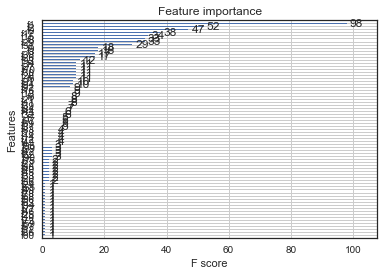

In [70]:
X_train, X_test, y_train, y_test = train_test_split(decomposed, train['toxic'], 
                                                        test_size=0.1, random_state=7)

xgbC = XGBClassifier()
xgbC.fit(X_train, y_train)

pred = xgbC.predict_proba(X_test)
#print(accuracy_score(y_test, pred))
print(log_loss(y_test, pred))

plot_importance(xgbC)

#### Explained variance for 100 SVD components

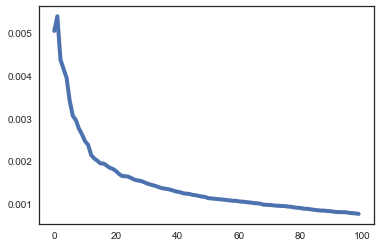

In [45]:
var_line = plt.plot(svd_obj.explained_variance_, label='Explained Variance', linewidth=4)

#### Try other estimators

In [36]:
clf1 = LogisticRegression(random_state=8)
clf2 = GaussianNB()
clf3 = XGBClassifier()

target = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

data = {}
for i in target:
    X_train, X_test, y_train, y_test = train_test_split(decomposed, np.ravel(train[i]), 
                                                        test_size=0.1, random_state=7)

    for clf in [clf1, clf2, clf3]:
        clf_name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)
        result = log_loss(y_test, pred)
        data.update({str(clf_name)+ ' estimation for ' + str(i): result})          
        #print('\n log loss score for ' + clf_name + ' estimating for '+  str(i) + ' is: '+ str(result))
            

#### XGBoost and LogisticRegression are working best for all of the targets, as they have the lowest log loss scores.

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text xticklabel objects>)

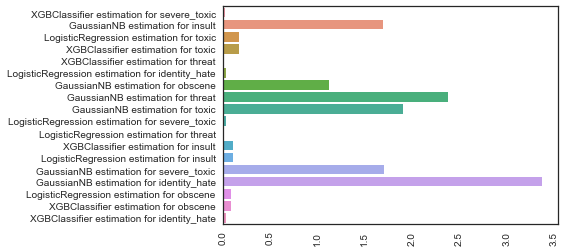

In [37]:
import seaborn as sns

sns.set(style='white')

g = sns.barplot(x=list(data.values()), y=list(data.keys()))
plt.xticks(rotation=90)

#### Pipeline and gridsearch for parameter tuning, for optimal size of data and reduction, then for the estimator if time is allowed

In [ ]:
pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', strip_accents='unicode', norm='l1', stop_words='english')),
                           ('svd', TruncatedSVD()),
                           #('lgr', LogisticRegression()),
                           ('xgb', XGBCLassifier()),])

params = {
    'tfidf__max_features': (12000, 13000, 15000),
    #'tfidf__ngram_range': ((1,2), (1,3)),
    'svd__n_components': (60, 80, 100),
}

grid = GridSearchCV(pipeline, params, n_jobs=1, verbose=1)

for j in target:
    grid.fit(train['comment_text'], train[j])
    
param_test1 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]}

 
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[8,9,10]}

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]}


param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}


param_test5 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3]}


param_test6 = {
 'reg_alpha':[0.1, 0.2, 0.3]}

param_test6dot5 = {
 'reg_alpha':[1e-7, 1e-8, 1e-9]}

param_test7 = {
   'learning_rate':[0.11, 0.12, 0.13]}

param_test8 = {
   'learning_rate':[0.13""" 0.14, 0.15"""]}

#Optimal parameters for this tree
grid = GridSearchCV(estimator=XGBClassifier(learning_rate=0.13,
                  n_estimators=55,
                  max_depth=5,
                  min_child_weight=8,
                  gamma=0,
                  subsample=0.9,
                  colsample_bytree=0.6,
                  objective='multi:softprob',
                  nthread=4,
                  scale_pos_weight=1,
                  reg_alpha=0.0001,
                  seed=7), 
                     param_grid = param_test8, scoring='log_loss',n_jobs=4, cv=5)

## Embedding model

In [55]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Flatten, Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

C:\Users\mingt\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [56]:
tkn = Tokenizer(num_words=15000)
tkn.fit_on_texts(train['comment_text'])
seq = tkn.texts_to_sequences(train['comment_text'])
data = pad_sequences(seq, maxlen=100)

In [63]:
model = Sequential()
model.add(Embedding(15000, 200, input_length=100))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(200))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
target2 = to_categorical(train['toxic'])

hist = model.fit(data, target2, validation_split=0.1, batch_size = 32, epochs=3)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 584s 4ms/step - loss: 0.1252 - acc: 0.9560 - val_loss: 0.1054 - val_acc: 0.9600
Epoch 2/3
143613/143613 [==============================] - 593s 4ms/step - loss: 0.0866 - acc: 0.9677 - val_loss: 0.1119 - val_acc: 0.9572
Epoch 3/3
143613/143613 [==============================] - 586s 4ms/step - loss: 0.0610 - acc: 0.9772 - val_loss: 0.1192 - val_acc: 0.9580


### This preliminary embedding model took about 30 minutes to train, and the graph shows best validation log loss score of 0.1192

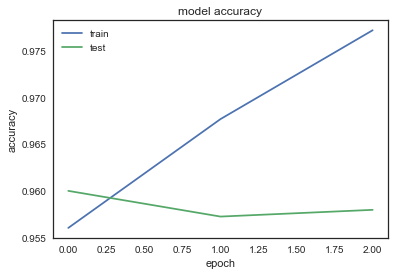

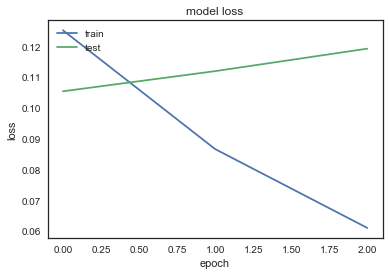

In [66]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Preliminary Conclusion: Bag-of-Words model achieved 0.1696, and Embedding model achieved 0.1192 log loss. The lower the log loss score, the higher the accuracy of the estimator.